# Lung Cancer Metastasis

Rahul Sharma    <br>
Date:7/8/2021 

Objective: We need to measure how quickly the lung cancer cells can fill the wound which shows us their mobility


Completed:
1. Optimized threshold values at 3.8, cropping dimensions at [500:1200, 300:1200], and window size for entropy calculation at 8
2. Rewrote the code in terms of obkect orientied programming to better increase the functionality of the tool
3. Determined a new method of calculating the wound boundary using the second dervivtive of the entropy graph at each y level and then finding the 2 closest inflection points to the void
4. Packaged all of the data into a csv which tells file name, plate name, well name, num of hours elapsed, the area of the wound in terms of pixels, and the area of the wound in terms of percentage to the cropped area. 

Next Steps:
1. To add automatic thresholding
2. Add automatic guassaian blur by changing the window size 
3. Add automatic cropping

## Imports

In [241]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2gray
from skimage import io
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import os, re
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Circle
from scipy.ndimage import gaussian_filter1d

## Classes

In [300]:
class MicroscopyImage():
    """
    Class that orginizes the images of the petridish and appends all of the relevenet data to each image
    """

    def __init__(self, root, img_name, dish_name, original_img, cropped_img, grayscale_img, entropy_img, binary_mask):
        """ 
        Creates objects called microscopy images and it adds the various data to the image

       Args:
            root (str): file directory
            img_name (str): name of the microscopy image
            dish_name (str): name of the dish where the images originate from
            original_img : Original microscopy image
            cropped_img: image that is cropped by [500:1200, 300:1200]
            grayscale_img: image that is converted into grayscale from RBG, and converted into ubyte
            entropy_img: image of the entropy values
            binary_mask: image of the binary mask
        """
        self.root = root
        self.img_name = img_name
        self.dish_name = dish_name
        self.original_img = original_img
        self.cropped_img = cropped_img
        self.grayscale_img = grayscale_img
        self.entropy_img = entropy_img
        self.binary_mask = binary_mask
  
    @property
    def num_void_pixels(self):
        """ 
       Adds up the value of the binary mask under the threshold in order to see the pixel count of the void
       Args: self
           Returns self.binary_mask.sum() which is the integer of the binary masked sumed 
        """
        return self.binary_mask.sum()
    
    def plot_entropy(self):
         """ 
       plots the entropy values that were caculated. The numpy array is then expressed as a graph
        """
        plt.title("Entropy Plot")
        plt.imshow(self.entropy_img)
        plt.show()
        
        
    
    #### Inflection-Based Segmentation
    def plot_inflection_boundaries(self):
         """ 
       Plots the inflection points 
        """
        index_to_inflx_points = self.get_index_to_inflx_points()
        inflx_markers = MicroscopyImage.get_inflx_markers(index_to_inflx_points)
        self.plot_inflx_markers_overlay_cropped(inflx_markers)

    @staticmethod
    def get_smooth_smooth_d2_and_inflx_pts(data_array):
        """ 
       Smooths the entropy curve by doing a gaussian filter and this reduces irregularies with a window size of 100. 
       Then the second derivitve is calulated from the smooth entropy graph. Using the second derivitive graph the 
       inflections are dervied. It is then filtered based on the maximum of the 2nd derivitve graph. The 2 closest 
       inflections points are put into a list.
       
       Args:
       data_array = numpy array which is the entropy data
       
       Returns:
       smooth = numpy array of the smoothen entropy values
       smooth_d2 = the second dervitive of the smooth graph
       infls = list of the inflection points, it has the x and y values of thier cordinates
        """
        # smooth
        smooth = gaussian_filter1d(data_array, 100)
        # compute second derivative
        smooth_d2 = np.gradient(np.gradient(smooth))
        # find switching points
        infls = np.where(np.diff(np.sign(smooth_d2)))[0]
        # Find the X Value of Max Point in Smooth D2
        y_max = max(smooth_d2)
        x_pos_at_y_max = list(smooth_d2).index(y_max)
        # Filter Infls
        infls = MicroscopyImage.filter_infs_points(x_pos_at_y_max, infls)
        return smooth, smooth_d2, infls

    # Filter Inflex Point Function
    @staticmethod
    def filter_infs_points(x_pos_at_y_max, infls):
        """
        Filters the inflection points by using the maxiumum of the smooth_d2 values. Then it find the 2 closest inflection 
        points and filters the rest of the extra inflection points
        
        Args: x_pos_at_y_max = the list of the maximum values for the smooth_d2 graph
              infls = list of all of the inflection points per each y value
              
        Returns: curr_infls_pt = the first x value that corresponds to th
        """
        for i in range(len(infls)-1):
            curr_infls_pt = infls[i]
            next_infls_pt = infls[i+1]
            if x_pos_at_y_max > curr_infls_pt and x_pos_at_y_max < next_infls_pt:
                return[curr_infls_pt, next_infls_pt]
        
    @staticmethod
    def plot_smooth_smooth_d2_and_inflx_pts(data_array, smooth, smooth_d2, infls):
        plt.title("Plot Original Data, Smoothened Data, 2nd Derviative, and Inflection Points.")
        plt.xlabel("Pixel X Coordinate")
        plt.ylabel("Entropy Value")
        plt.plot(data_array, label='Noisy Data')
        plt.plot(smooth, label='Smoothed Data')
        plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
        for i, infl in enumerate(infls, 1):
            plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
        plt.legend(bbox_to_anchor=(1.55, 1.0))
        plt.show()

    def plot_smooth_smooth_d2_and_inflx_pts_by_entropy_img_row_id(self, entropy_img_row_id=300):
        data_array = self.entropy_img[entropy_img_row_id]
        smooth, smooth_d2, infls = MicroscopyImage.get_smooth_smooth_d2_and_inflx_pts(row)
        MicroscopyImage.plot_smooth_smooth_d2_and_inflx_pts(data_array, smooth, smooth_d2, infls)
        
    def get_index_to_inflx_points(self):
        index_to_inflx_points = {}
        for idx, row in enumerate(self.entropy_img):
            smooth, smooth_d2, infls = MicroscopyImage.get_smooth_smooth_d2_and_inflx_pts(row)
            index_to_inflx_points[idx] = infls
        return index_to_inflx_points

    @staticmethod
    def get_inflx_markers(index_to_inflx_points):
        inflx_markers = []
        for y_cord, x_inflx_pts in index_to_inflx_points.items():
            for x_inflx_pt in x_inflx_pts:
                marker = (x_inflx_pt, y_cord)
                inflx_markers.append(marker)
        return inflx_markers

    
    def plot_inflx_markers_overlay_cropped(self, inflx_markers):
        patches = []
        for inflx_marker in inflx_markers:
            circle_object = Circle(inflx_marker, radius=2, color='red')
            patches.append(circle_object)
        fig, ax = plt.subplots(1)
        ax.imshow(self.entropy_img)
        for p in patches:
            ax.add_patch(p)
        plt.show(fig)

    @property
    def area_between_inflx_pts(self):
        """ 
       Adds up the value of the binary mask under the threshold in order to see the pixel count of the void
       Args: self
           Returns self.binary_mask.sum() which is the integer of the binary masked sumed 
        """            
        index_to_inflx_points = self.get_index_to_inflx_points()
        area = 0
        for inflx_pts in index_to_inflx_points.values():
            if inflx_pts is None:
                continue
            x_1, x_2 = inflx_pts
            area_single_row = x_2 - x_1
            area += area_single_row
        return area

    @property
    def pct_area_of_cropped_img(self):          
        width, height, num_channels = sample_microscopy_img.cropped_img.shape
        pct_area_of_cropped_img = (self.area_between_inflx_pts/(width * height))
        return pct_area_of_cropped_img


In [301]:
class PetriDish():
    """
    Creates a class which holds the list of the MicroscopyImage objects that orginate from the PetriDish.
    """
    def __init__(self, dish_name, microscopy_images):
        """
        Args:
            dish_name (str): Name of the petri dish.
            microscopy_images (List[MicroscopyImage]): All Microscopy Image objects in Petri Dish
        
        """
        self.dish_name = dish_name
        self.microscopy_images = microscopy_images

    def plot_num_void_pixel_across_images(self):
        num_void_pixels = [x.num_void_pixels for x in self.microscopy_images]
        plt.plot(num_void_pixels)
        plt.show()
        
        
    def plot_area_percent_void_pixel_across_images(self):
        area_percent_void_pixels = [x.pct_area_of_cropped_img for x in self.microscopy_images]
        plt.plot(area_percent_void_pixels)
        plt.show()

In [312]:
class PetriDishFactory():
    
    def __init__(self, root, dish_name_to_img_list):
        self.root = root
        self.dish_name_to_img_list = dish_name_to_img_list

    
    def read_image(self, image_name):
        image_path = os.path.join(self.root, image_name)
        image = io.imread(image_path)
        return image

    @staticmethod
    def gen_grayscale_img(img):
        grayscale_img = rgb2gray(img)
        grayscale_img = img_as_ubyte(grayscale_img)
        return grayscale_img

    @staticmethod
    def gen_entropy_img(img):
        return entropy(img, disk(9))

    @staticmethod
    def gen_binary_mask(entropy_img, upper_threshold):
        binary_mask = entropy_img <= upper_threshold
        binary_mask = binary_mask.astype(float)
        return binary_mask
    
    def create_petri_dishes(self):
        all_petri_dishes = []
        # Temporary Line
        self.dish_name_to_img_list = {
            #"F2": self.dish_name_to_img_list["F2"],
            "E10": self.dish_name_to_img_list["E10"]
        }
        # Iterate through all dishes and associated images for that dish
        for dish_name, sorted_img_file_names in self.dish_name_to_img_list.items():
        
            petri_dish_microscopy_images = []

            # Iterate through all images associated for current dish
            for img_name in sorted_img_file_names[:]:
                # Conduct Pipeline Preprocessing
                original_img = self.read_image(img_name)
                cropped_img = original_img[500:1200, 300:1200]
                grayscale_img = PetriDishFactory.gen_grayscale_img(cropped_img)
                entropy_img = PetriDishFactory.gen_entropy_img(grayscale_img)
                binary_mask = PetriDishFactory.gen_binary_mask(entropy_img, upper_threshold=3)

                # Store Processed Data into MicroscopyImage object
                microscopy_image_object = MicroscopyImage(
                    ROOT_PATH, img_name, dish_name, original_img, cropped_img, grayscale_img, entropy_img, binary_mask
                )
                # Add to Petri Dish MicroscopyImage list
                petri_dish_microscopy_images.append(microscopy_image_object)

            # Make the Petri Dish Class
            petri_dish = PetriDish(dish_name, petri_dish_microscopy_images)
            # Add to Our Full List of PetriDishes
            all_petri_dishes.append(petri_dish)
        return all_petri_dishes

## Functions

In [313]:
def get_sorted_img_file_names(root_path, regex_pattern):
    """
    Args:
        root_path (str): Path to file directory containing images.
        regex_pattern (str): Pattern to match images (by type). (Ex: '.*jpg')
    Return:
        sorted_img_file_names (List[str]): List of sorted file names that match the given regex
            pattern.
    """
    all_files = os.listdir(root_path)
    regex = re.compile(regex_pattern)
    sorted_img_file_names = list(filter(regex.search, all_files))
    sorted_img_file_names.sort()
    return sorted_img_file_names

In [314]:
def get_dish_name_to_img_list(sorted_img_file_names):
    """ Groups File Names by the Corresponding Dish Name. (Ex: E12)
    Args:
        sorted_img_file_names (List[str]): List of sorted file names that match the given regex
            pattern.
    Returns:
        dish_name_to_img_list (Dict[str, List[str]]): Mapping between dish name and associated image files.
    """
    dish_name_to_img_list = {}
    for img_file_name in sorted_img_file_names:
        dish_name = img_file_name.split("_")[1]

        # Update Dictionary Mapping
        if dish_name not in dish_name_to_img_list:
            dish_name_to_img_list[dish_name] = [img_file_name]
        else:
            dish_name_to_img_list[dish_name].append(img_file_name)
    return dish_name_to_img_list

### Plotting

In [315]:
def plot_num_images_per_dish(dish_name_to_img_list):
    """ Plots the number of images per dish name.
    Args:
        dish_name_to_img_list (Dict[str, List[str]]): Mapping between dish name and associated image files.
    """
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    dish_names = []
    images_per_dish_name = []
    for dish_name, image_list in dish_name_to_img_list.items():
        dish_names.append(dish_name)
        images_per_dish_name.append(len(image_list))
    ax.bar(dish_names,images_per_dish_name)
    # TODO: Add title, axis labels, etc
    plt.show()

In [316]:
def visualization(masks_dict):
    """ Plots multiple masks for a single image.
    Args:
        masks_dict (Dict[String, Np Arr]): A dictionary that holds the masks for a given image.
            The key is the name of the maks and the value is the numpy array of the mask data.
            Example:
                masks_dict = {
                    "Original Image": original_img,
                    "Entropy Mask": entropy_img,
                    "Binary Mask": binary_mask
                }
    """
    plt.figure(figsize=(15, 15))
    for i, (mask_type, mask) in enumerate(masks_dict.items()):
        plt.subplot(1, len(masks_dict), i + 1)
        plt.title(mask_type)
        plt.imshow(np.array(mask))
        plt.axis("off")
    plt.show()

### Output

In [317]:
def convert_raw_hours_to_hours(raw_hours):
    days = int(raw_hours[0:2])
    hours = int(raw_hours[3:5])
    total_hours = days * 24 + hours
    return total_hours

In [318]:
def convert_petri_dishes_to_csv(all_petri_dishes, output_file_name):
    all_image_data = []
    for petri_dish in all_petri_dishes:
        for microscopy_img in petri_dish.microscopy_images:
            full_file_name = microscopy_img.img_name
            file_name, file_ext = full_file_name.split(".")
            dish_name, dish_number, _, raw_hours = file_name.split("_")
            total_hours = convert_raw_hours_to_hours(raw_hours)
            area_pixels = microscopy_img.area_between_inflx_pts
            area_percent = microscopy_img.pct_area_of_cropped_img

            image_data = {
                "full_file_name": full_file_name,
                "dish_name": dish_name,
                "dish_number": dish_number,
                "hours": total_hours,
                "area (pixels)": area_pixels,
                "area percentage": area_percent
            }
            all_image_data.append(image_data)
    pd.DataFrame.from_dict(all_image_data, orient='columns').to_csv(output_file_name)

## Workflow

In [319]:
ROOT_PATH = '.\Inc110_image_files_tif'
IMG_REGEX_PATTERN = '.*tif'

In [320]:
sorted_img_file_names = get_sorted_img_file_names(ROOT_PATH, IMG_REGEX_PATTERN)

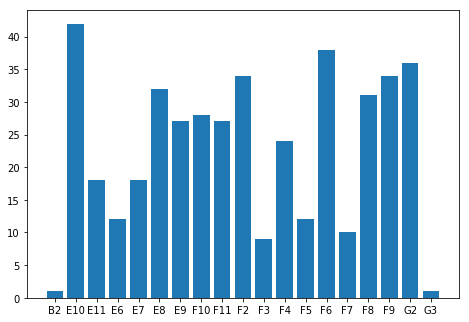

In [321]:
dish_name_to_img_list = get_dish_name_to_img_list(sorted_img_file_names)
plot_num_images_per_dish(dish_name_to_img_list)

In [322]:
# Create Petri Dish Factory
petri_dish_factory = PetriDishFactory(ROOT_PATH, dish_name_to_img_list)

In [323]:
# Generate All Petri Dish Objects
all_petri_dishes = petri_dish_factory.create_petri_dishes()

In [ ]:
# Generate CSV with Data from all Petri Dishes
convert_petri_dishes_to_csv(all_petri_dishes, "generated.csv")

## Sandbox

In [324]:
sample_microscopy_img = all_petri_dishes[0].microscopy_images[1]

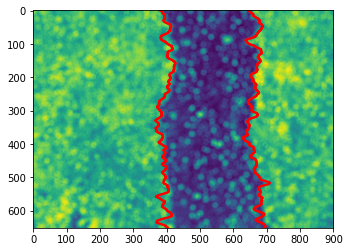

In [325]:
sample_microscopy_img.plot_inflection_boundaries()

In [279]:
sample_microscopy_img.pct_area_of_cropped_img

0.1378050443081118

In [259]:
index_to_inflx_points = sample_microscopy_img.get_index_to_inflx_points()

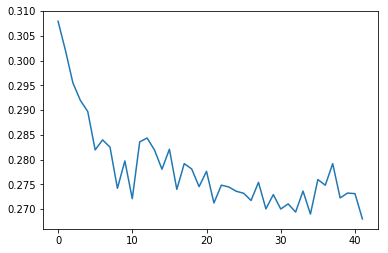

In [326]:
all_petri_dishes[0].plot_area_percent_void_pixel_across_images()

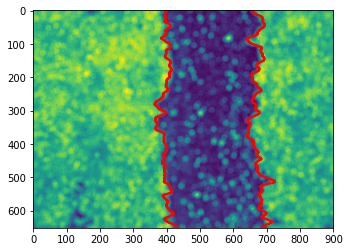

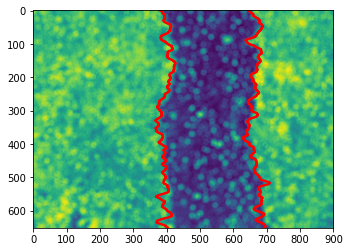

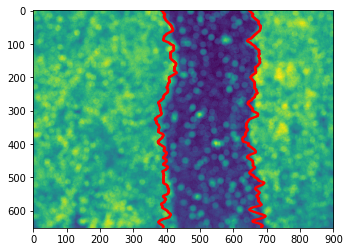

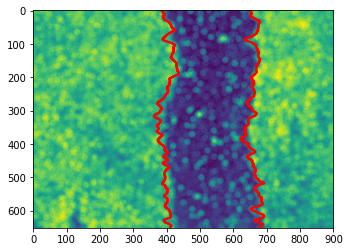

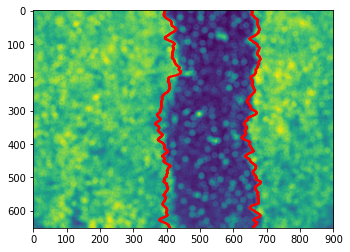

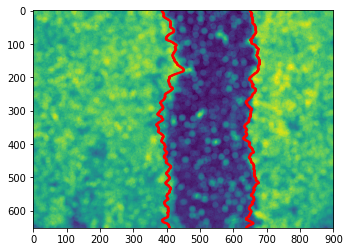

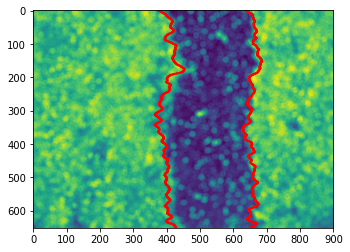

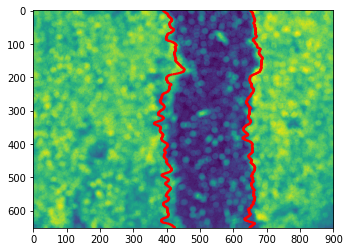

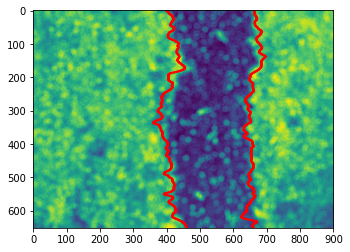

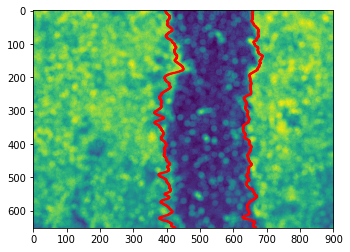

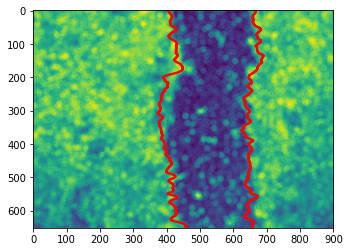

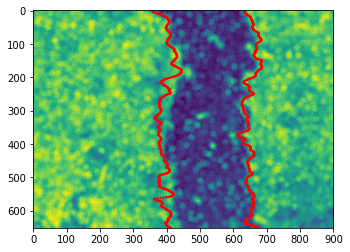

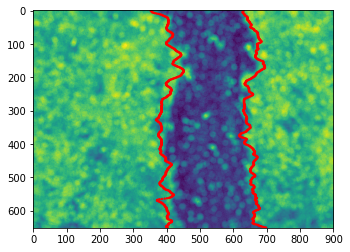

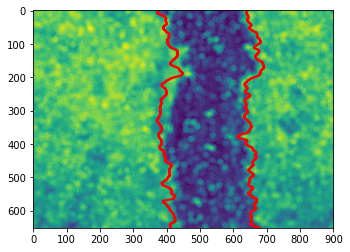

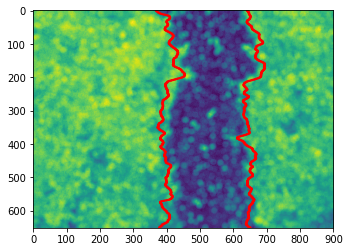

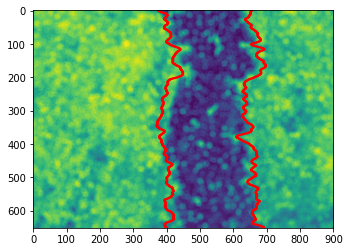

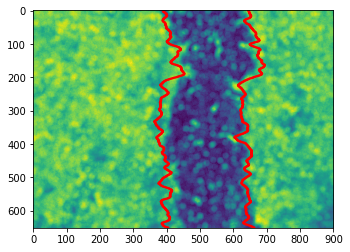

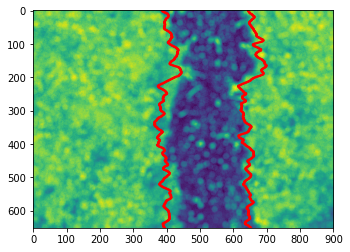

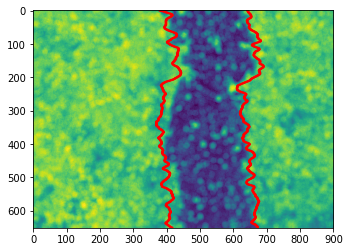

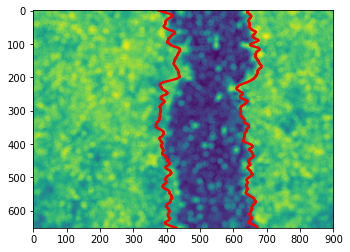

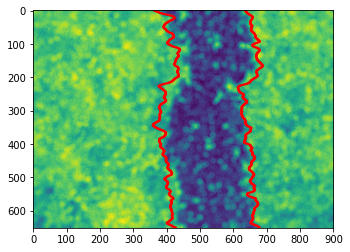

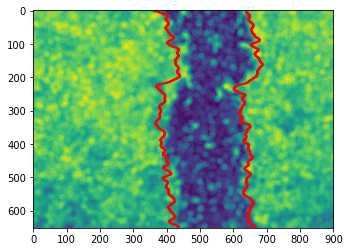

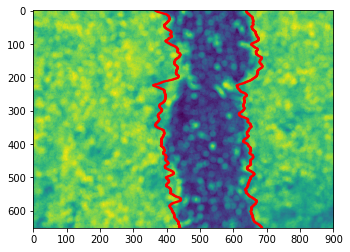

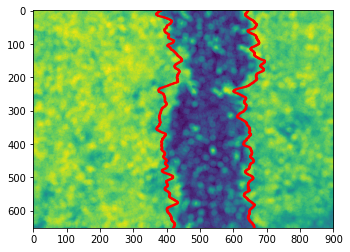

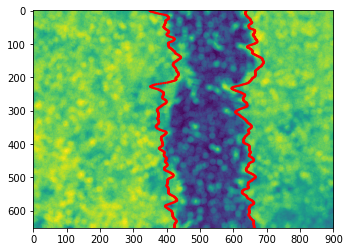

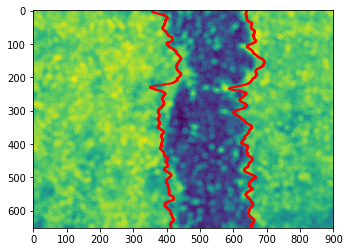

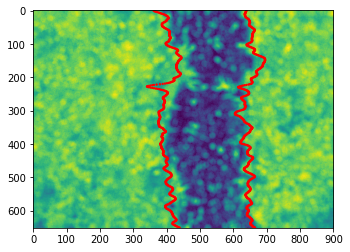

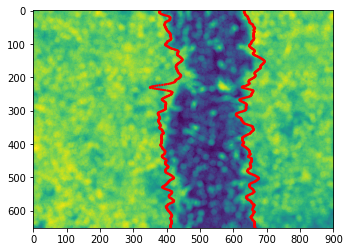

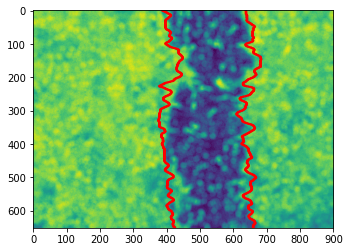

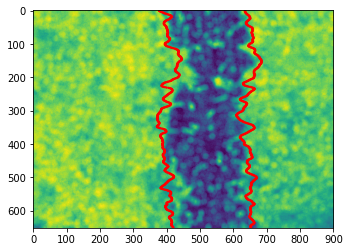

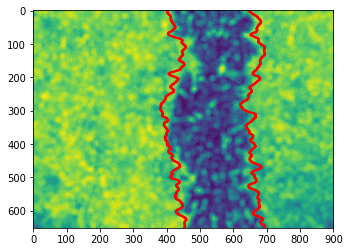

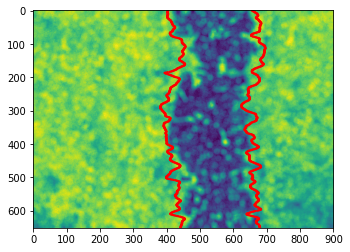

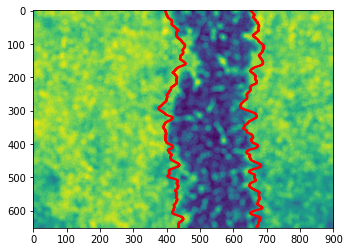

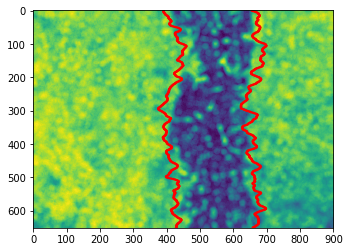

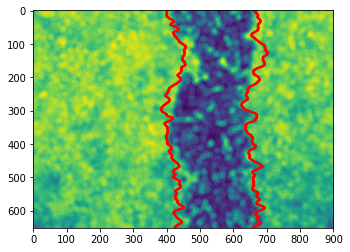

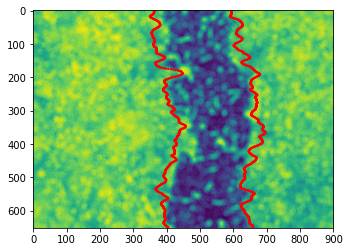

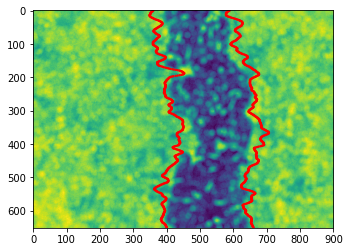

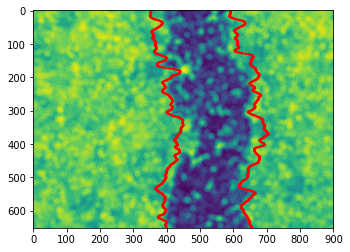

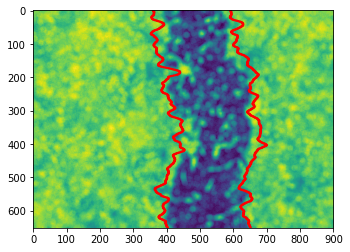

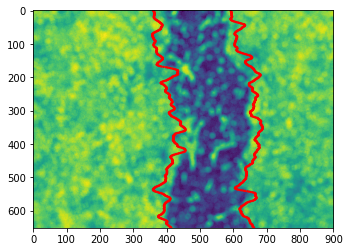

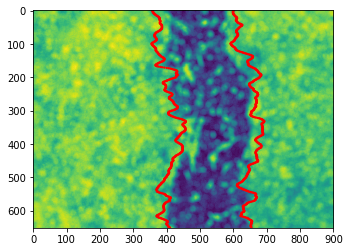

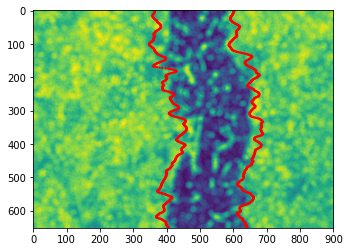

In [327]:
for x in all_petri_dishes[0].microscopy_images:
    x.plot_inflection_boundaries()